In [122]:
import numpy as np
import pandas as pd

In [123]:
data = pd.read_csv('data_mid.csv')
data.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,zero_crossing_rate
0,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,67649.0
1,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,73606.0
2,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,80433.0
3,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,64451.0
4,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,103725.0


In [124]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [125]:
data_final = data.drop(axis=1, columns=['age_onset', 'birthplace', 'filename', 'speakerid', 'country'])
data_final.head(7)

,age,native_language,sex,zero_crossing_rate
0,20.0,amharic,female,67649.0
1,29.0,amharic,female,73606.0
2,24.0,amharic,female,80433.0
3,26.0,amharic,female,64451.0
4,28.0,amharic,female,103725.0
5,31.0,amharic,male,56742.0
6,23.0,amharic,male,64163.0


In [126]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 4 columns):
age                   1045 non-null float64
native_language       1045 non-null object
sex                   1045 non-null object
zero_crossing_rate    1045 non-null float64
dtypes: float64(2), object(2)
memory usage: 32.7+ KB


Несмотря на то, что на семинаре мы считали задачу многофакторного анализа сложной в случае разной мощности ячеек (что, по очевидным причинам, присуще нашему датасету), положимся на хорошую реализацию метода в библиотеке $statsmodels$, закончим предобработку и сбор данных и перейдем непосредственно к третьему этапу нашей лабораторной работы - дисперсионному анализу.

In [160]:
lm = ols('zero_crossing_rate ~ C(native_language):C(sex) + C(age):C(sex) + C(age) + C(native_language) + C(sex)', data=data_final).fit()

In [162]:
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(age),74.0,9.827572e+10,1.328050e+09,1.855701,3.496606e-05
C(native_language),55.0,2.402635e+11,4.368428e+09,6.104057,7.929947e-34
C(sex),1.0,1.124812e+10,1.124812e+10,15.717127,7.983148e-05
C(native_language):C(sex),55.0,5.489639e+10,9.981162e+08,1.394680,3.360452e-02
C(age):C(sex),74.0,6.656446e+10,8.995197e+08,1.256910,7.735564e-02
Residual,838.0,5.997229e+11,7.156598e+08,NaN,NaN


In [163]:
table.values[:, 4].round(3)

array([0.   , 0.   , 0.   , 0.034, 0.077,   nan])

Связь с $C(native$ _ $language):C(age)$ и тройное взаимодействие исследовать данной реализацией не представляется возможным (выдает ошибку с размерностями, которая, видимо, возникает из-за слишком больших вариаций в $native$_$language$ и $age$)

Как мы видим, все $p-value$ меньше заданного уровня значимости 0.15, поэтому для дальнейшего анализа стоит разделить выборку по одному из признаков

In [164]:
import seaborn as sns

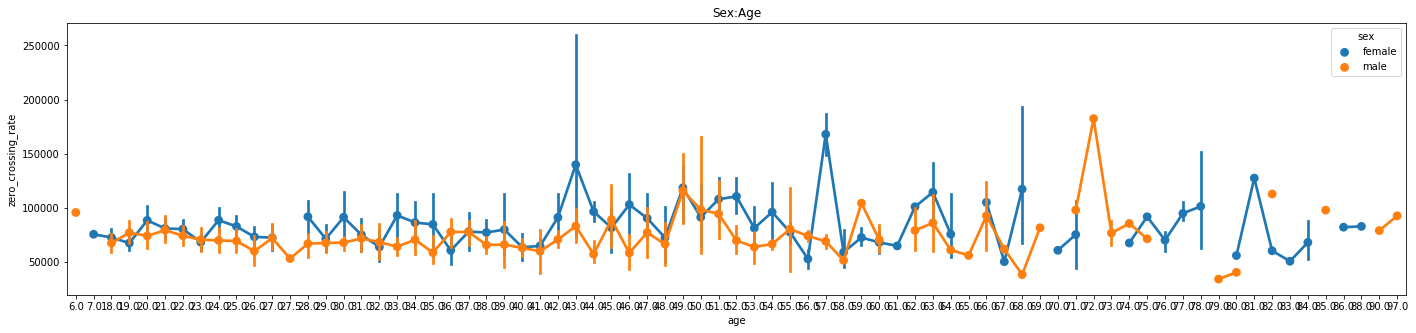

In [246]:
plt.figure(figsize=(24, 5))
plt.title('Sex:Age')
sns.pointplot(x="age", y="zero_crossing_rate", data=data_final, hue='sex')
plt.show()

Как мы видим, визуально график при $sex = male$ проходит ниже, чем при $sex = female$.

# Двухфакторный дисперсионный анализ речи женщин:

In [178]:
lm = ols('zero_crossing_rate ~  C(native_language) + C(age)',data=data.loc[data['sex']=='female']).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),42.0,1.998651e+11,4.758693e+09,7.237334,6.088009e-29
C(age),64.0,7.148357e+10,1.116931e+09,1.698702,1.337362e-03
Residual,398.0,2.616930e+11,6.575201e+08,NaN,NaN


У женцщин родной язык в целом оказывает большее влияние, чем возраст, но оба данных фактора признаем значимыми. Попробуем оценить влияние родного языка на разных возрастных группах (однофакторный анализ):

In [225]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='female') & (data['age'] <= 20)]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),18.0,2.558333e+10,1.421296e+09,2.672034,0.001814
Residual,69.0,3.670217e+10,5.319154e+08,NaN,NaN


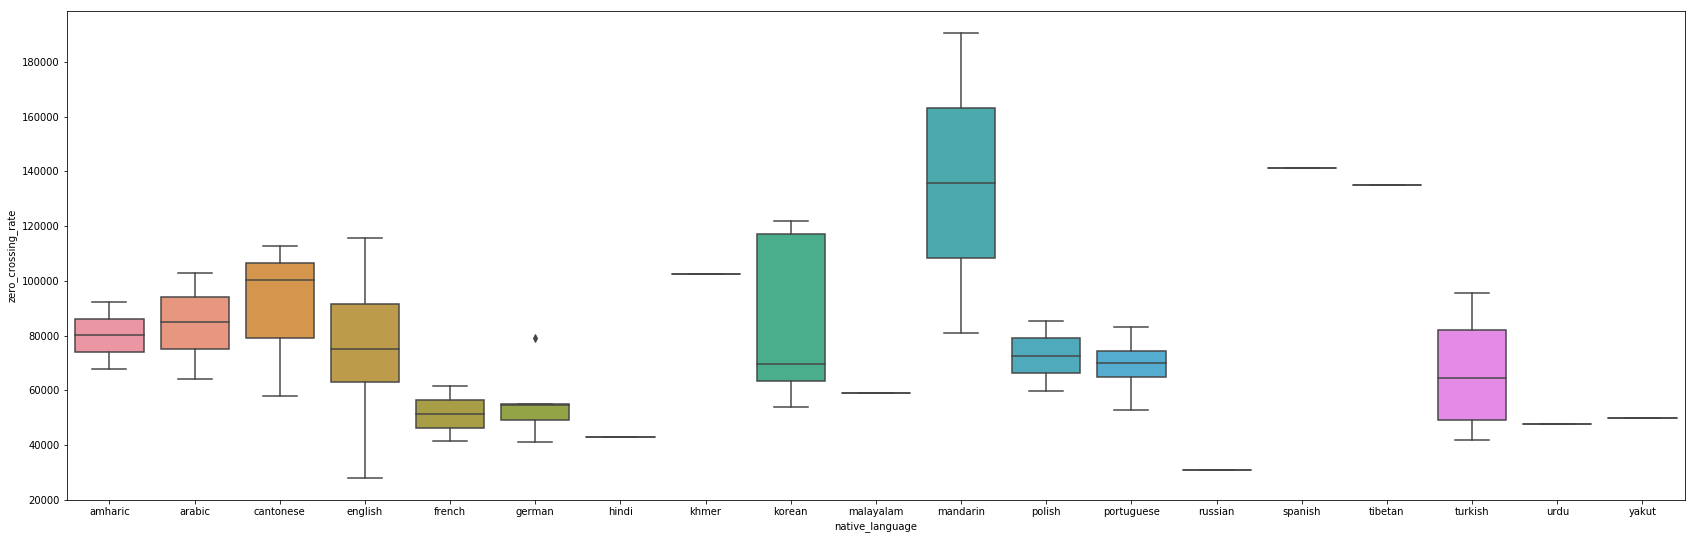

In [233]:
plt.figure(figsize=(29, 9))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='female') & (data['age'] <= 20)])

In [228]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='female') & (data['age'] <= 25) & (data['age'] > 20)]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),20.0,1.516330e+10,7.581649e+08,1.352226,0.163781
Residual,106.0,5.943200e+10,5.606792e+08,NaN,NaN


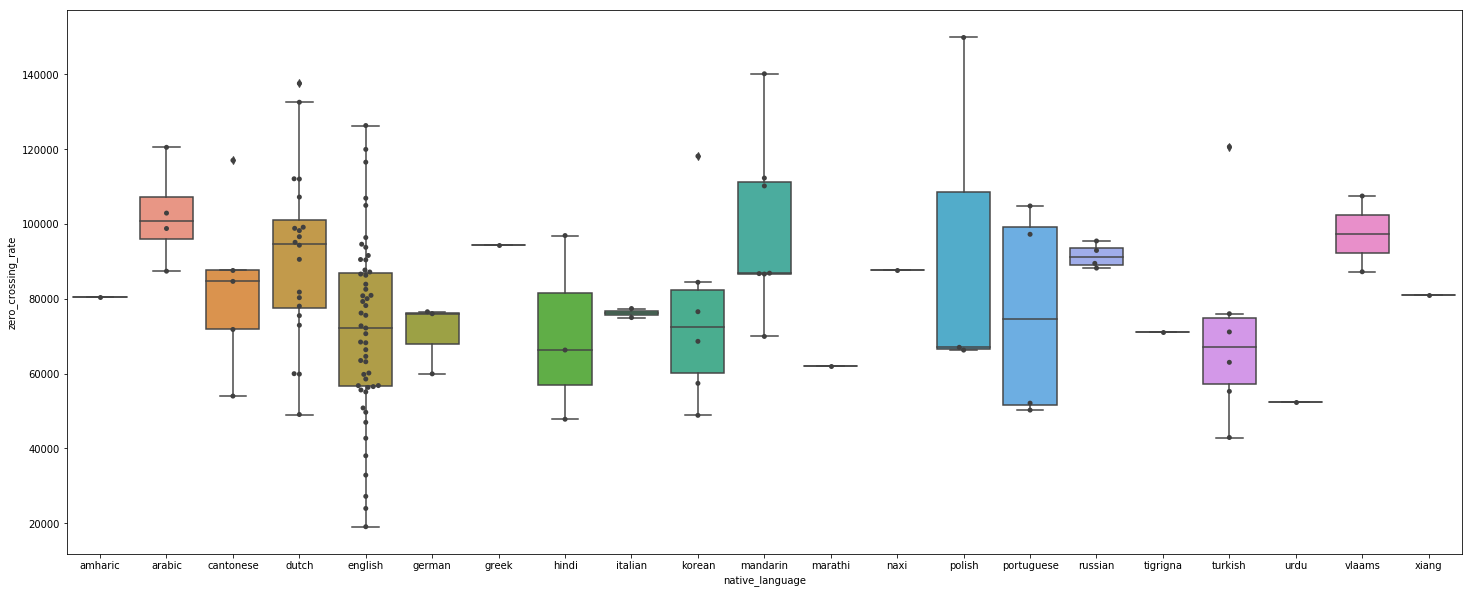

In [250]:
plt.figure(figsize=(25, 10))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='female') & (data['age'] <= 25) & (20 < data['age'])])
sns.swarmplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='female') & (data['age'] <= 25) & (20 < data['age'])], color=".25")

In [239]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='female') & (data['age'] <= 45) & (25 < data['age'])]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),25.0,1.522882e+11,6.091529e+09,7.878004,2.314851e-17
Residual,159.0,1.229440e+11,7.732325e+08,NaN,NaN


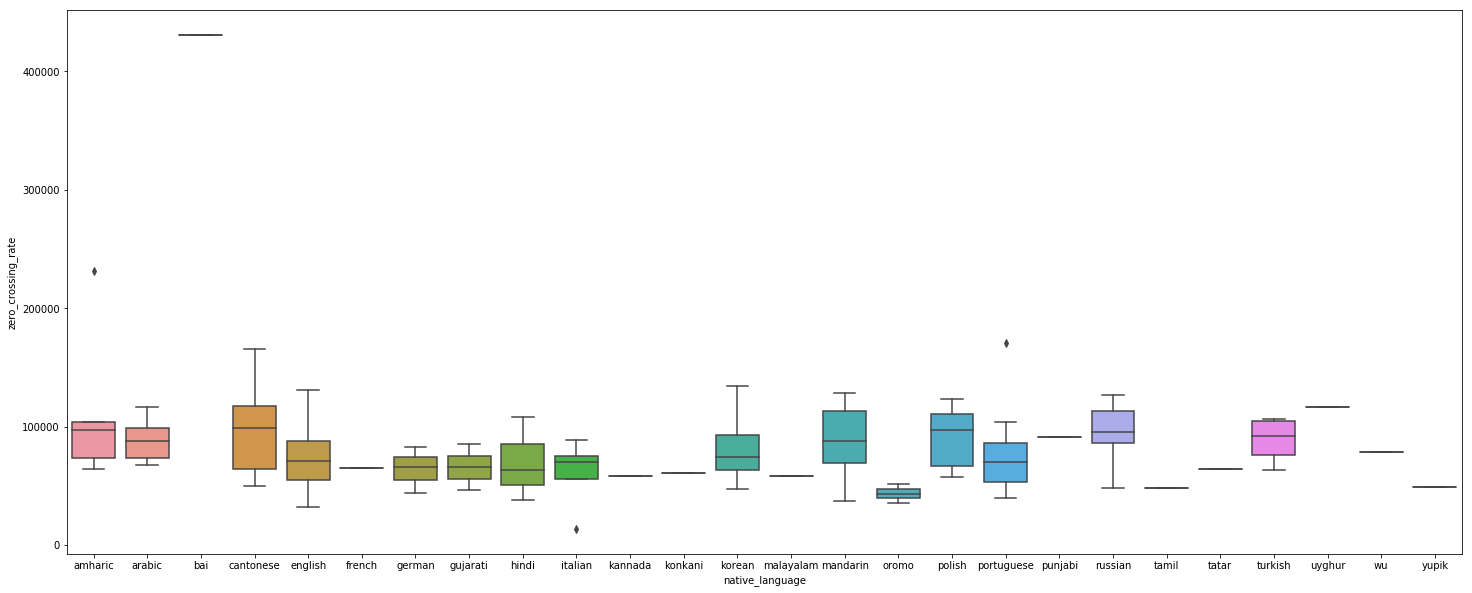

In [240]:
plt.figure(figsize=(25, 10))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='female') & (data['age'] <= 45) & (25 < data['age'])])

Заметим, что есть серьезный выброс с виде родного языка $bai$. Попробуем без него него:

In [241]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='female') & (data['age'] <= 45) & (25 < data['age']) & (data['native_language'] != 'bai')]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),24.0,2.889526e+10,1.203969e+09,1.55706,0.057191
Residual,159.0,1.229440e+11,7.732325e+08,NaN,NaN


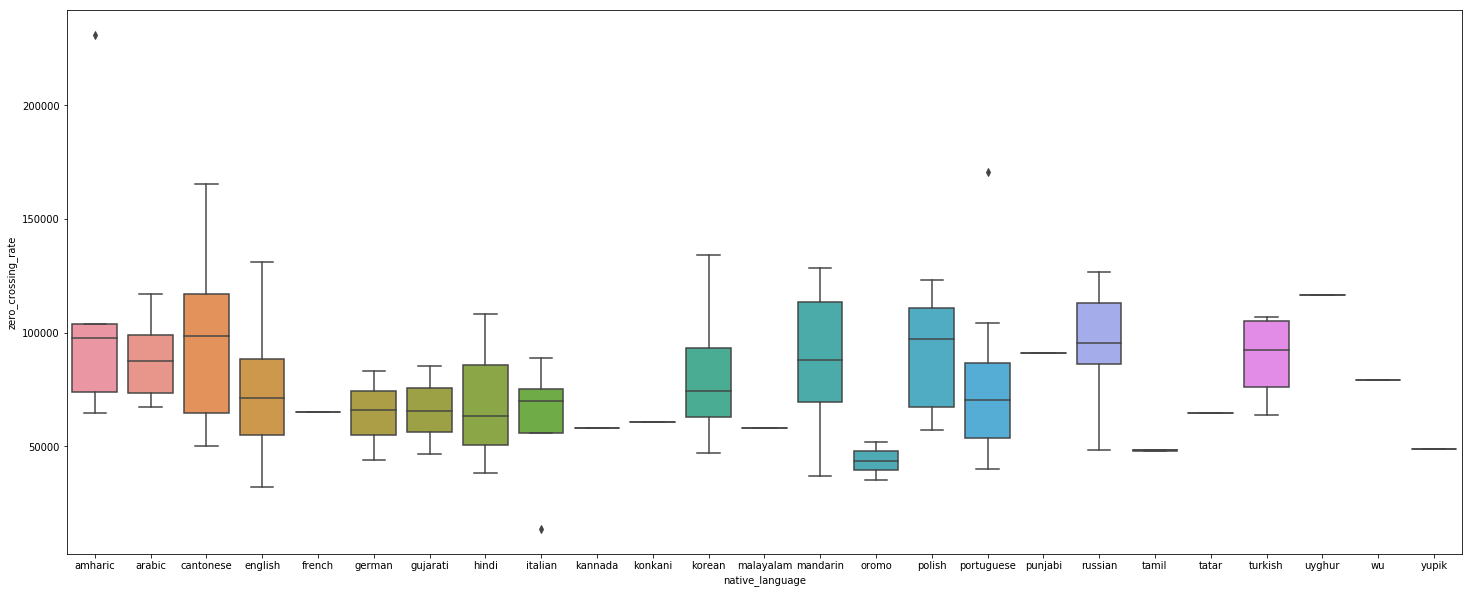

In [242]:
plt.figure(figsize=(25, 10))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='female') & (data['age'] <= 45) & (25 < data['age']) & (data['native_language'] != 'bai')])

In [231]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='female') & (data['age'] <= 60) & (45 < data['age'])]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),18.0,4.082490e+10,2.268050e+09,3.165821,0.000742
Residual,48.0,3.438805e+10,7.164176e+08,NaN,NaN


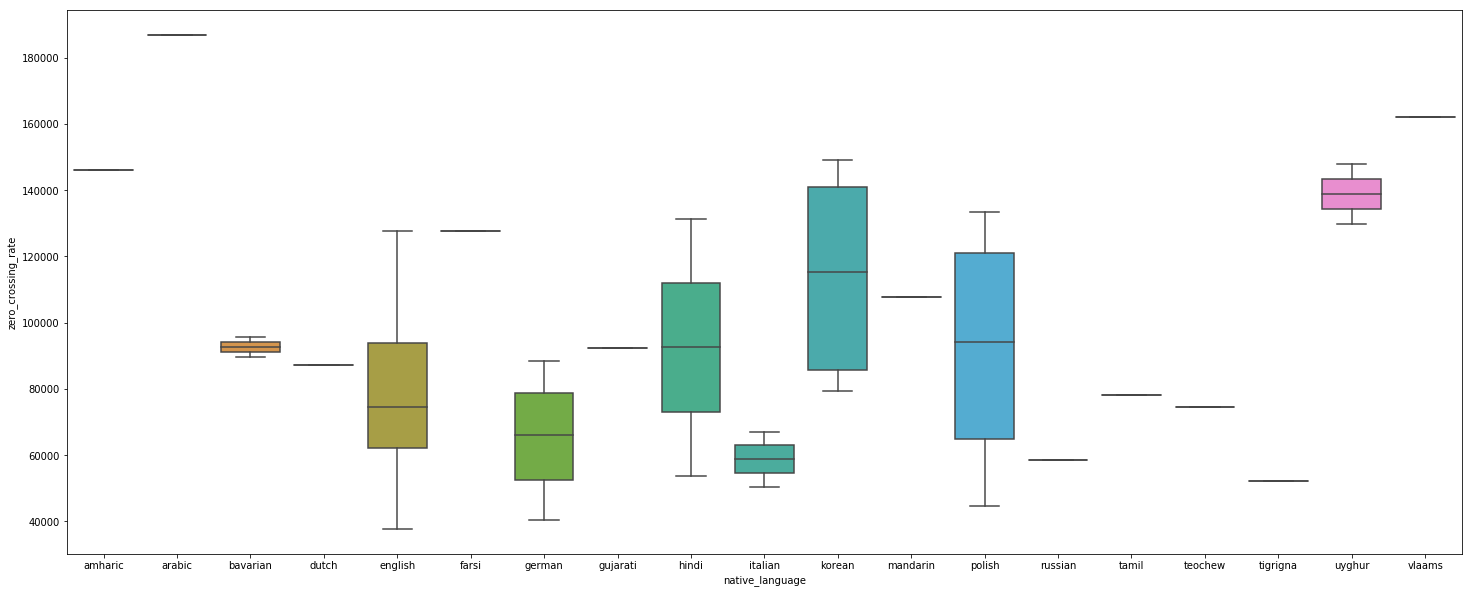

In [248]:
plt.figure(figsize=(25, 10))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='female') & (data['age'] <= 60) & (45 < data['age'])])

In [232]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='female') & (data['age'] >= 60)]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),8.0,1.544135e+10,1.930169e+09,2.567258,0.027548
Residual,32.0,2.405890e+10,7.518406e+08,NaN,NaN


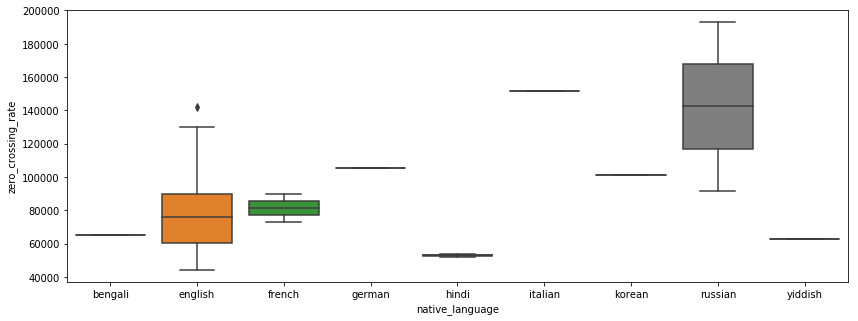

In [244]:
plt.figure(figsize=(14, 5))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='female') & (data['age'] >= 60)])

Промежуточные выводы:
* В целом наблюдается влияние родного языка на $zero$ $crossings$
* Однако выделяется группа девушек от 20 до 25 лет, в которой родной язык не оказывает (значимого) влияния на среднее значение данного признака
* Визуально не выявлено существенных различий в диапазоне изменения значений $zero$ $crossings$ у разных возрастных групп

# Двухфакторный дисперсионный анализ речи мужчин:

In [179]:
lm = ols('zero_crossing_rate ~  C(native_language) + C(age)',data=data.loc[data['sex']=='male']).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),38.0,6.978083e+10,1.836338e+09,2.390287,0.000015
C(age),63.0,4.945780e+10,7.850445e+08,1.021861,0.435931
Residual,440.0,3.380299e+11,7.682498e+08,NaN,NaN


Обнаружили, что у мужчин родной язык оказывает гораздо большее влияние на частоту звука речи, чем возраст (возраст вообще можно не учитывать при данном уровне значимости). Попробуем поделить участников эксперимента мужского пола на несколько возрастных групп и посмотрим, оказывает ли влияние родной язык в данных возрастных группах:

In [209]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='male') & (data['age'] <= 20)]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),20.0,5.532003e+10,2.766002e+09,3.749214,0.00001
Residual,86.0,6.344693e+10,7.377550e+08,NaN,NaN


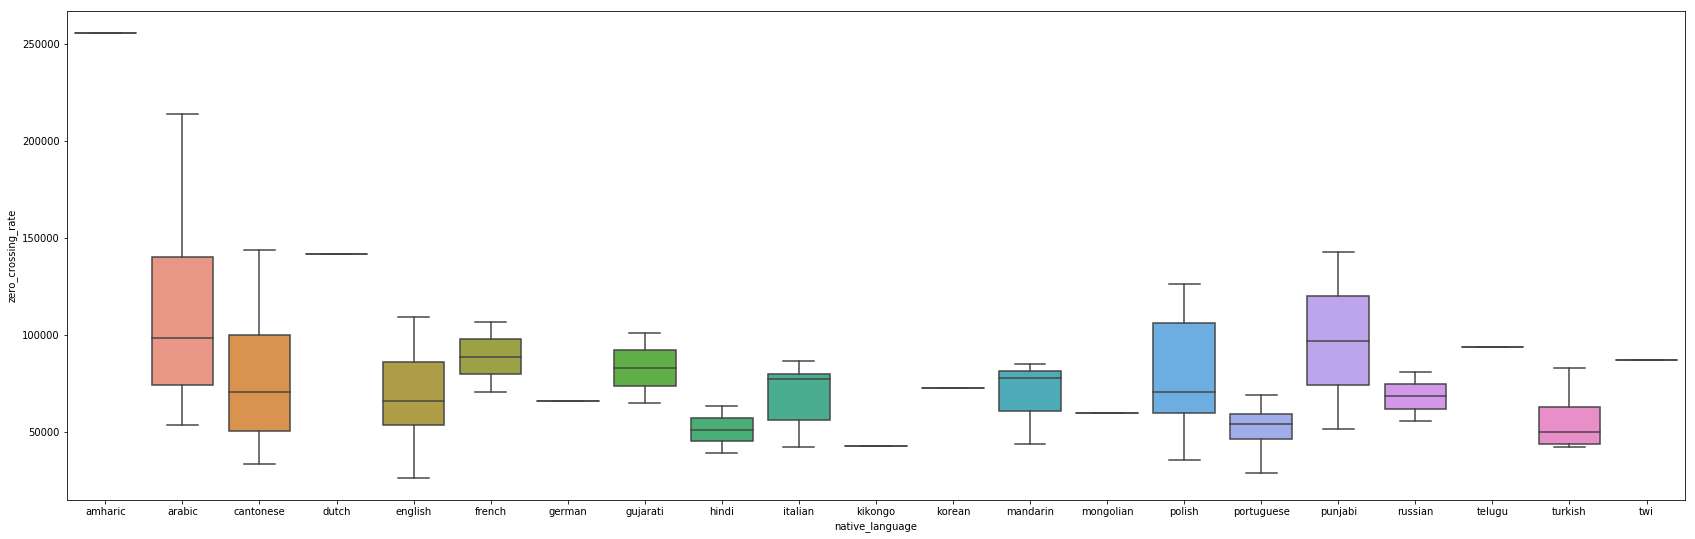

In [210]:
plt.figure(figsize=(29, 9))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='male') & (data['age'] <= 20)])

In [223]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='male') & (data['age'] <= 25) & (data['age'] > 20)]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),23.0,2.995087e+10,1.302212e+09,1.55873,0.064299
Residual,124.0,1.035934e+11,8.354309e+08,NaN,NaN


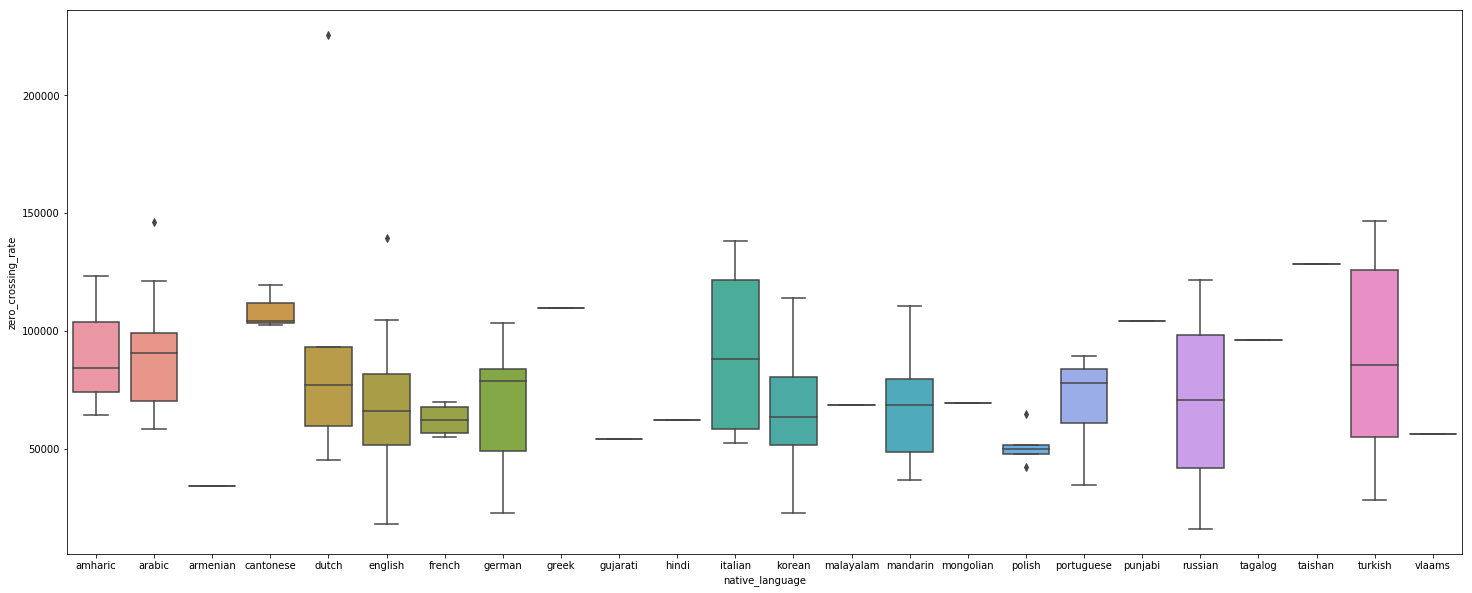

In [224]:
plt.figure(figsize=(25, 10))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='male') & (data['age'] <= 25) & (20 < data['age'])])

In [221]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='male') & (data['age'] <= 45) & (25 < data['age'])]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),25.0,9.194835e+09,3.677934e+08,0.684012,0.867504
Residual,165.0,8.872058e+10,5.377005e+08,NaN,NaN


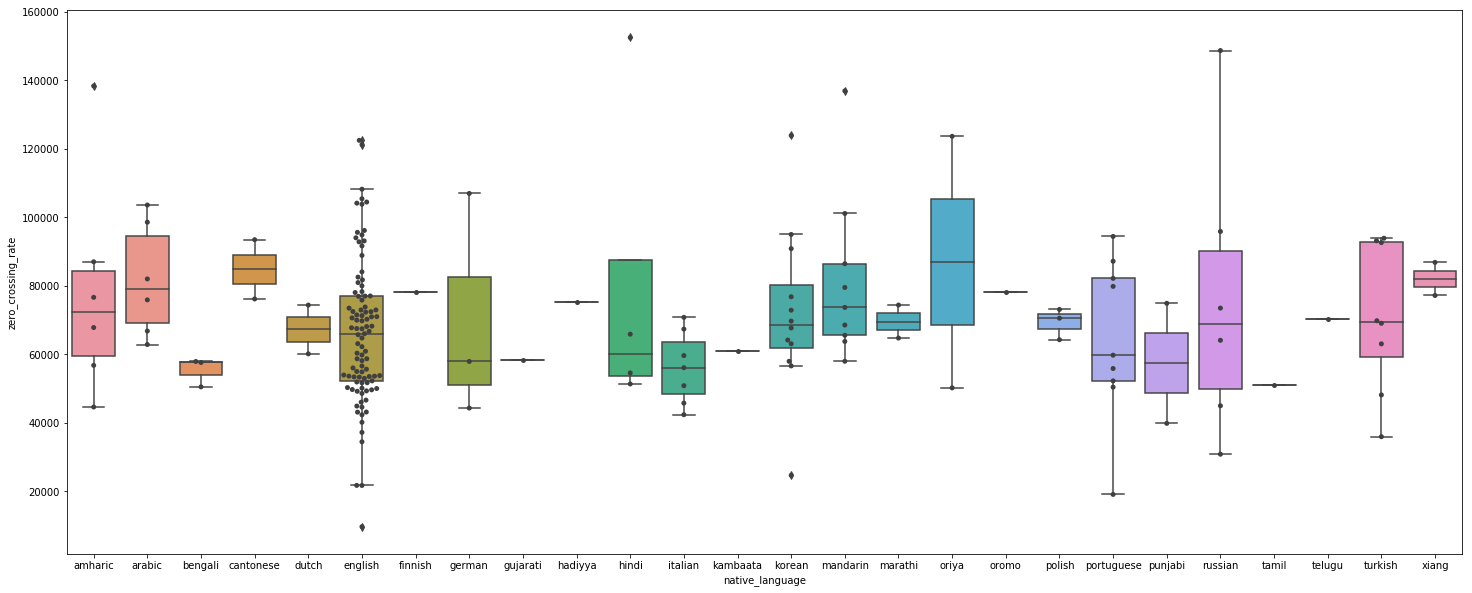

In [251]:
plt.figure(figsize=(25, 10))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='male') & (data['age'] <= 45) & (25 < data['age'])])
sns.swarmplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='male') & (data['age'] <= 45) & (25 < data['age'])], color=".25")

In [213]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='male') & (data['age'] <= 60) & (45 < data['age'])]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),13.0,4.041371e+10,3.108747e+09,5.314147,0.000005
Residual,54.0,3.158970e+10,5.849945e+08,NaN,NaN


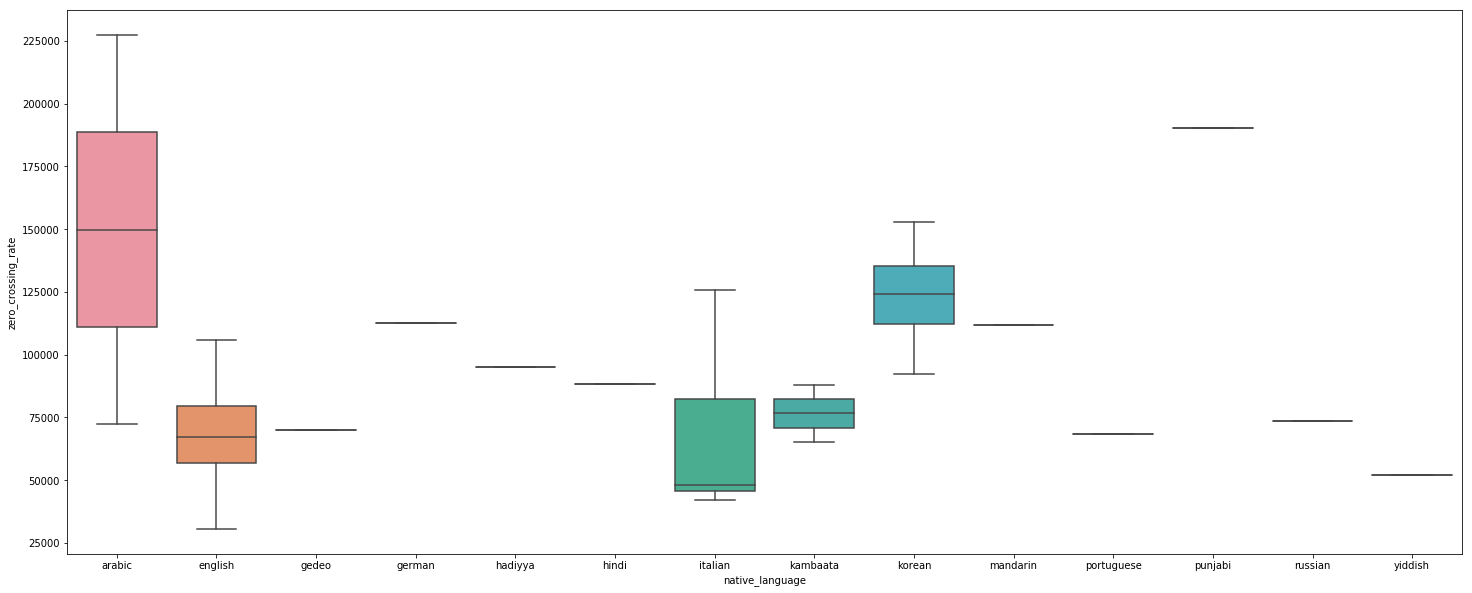

In [215]:
plt.figure(figsize=(25, 10))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='male') & (data['age'] <= 60) & (45 < data['age'])])

In [189]:
lm = ols('zero_crossing_rate ~  C(native_language)',data=data.loc[(data['sex']=='male') & (data['age'] >= 60)]).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),4.0,1.728957e+10,4.322393e+09,9.931296,0.000039
Residual,28.0,1.218643e+10,4.352295e+08,NaN,NaN


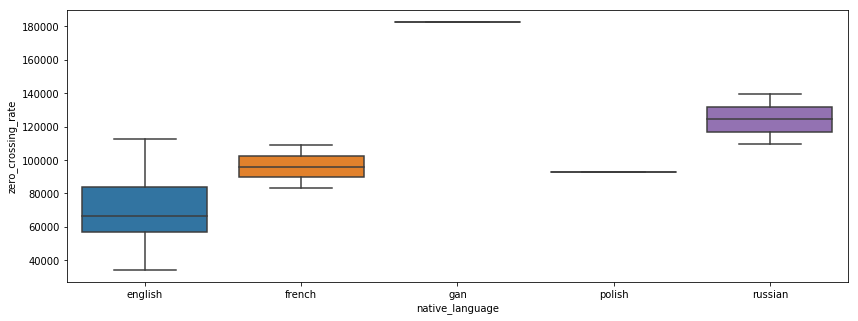

In [198]:
plt.figure(figsize=(14, 5))
sns.boxplot(x='native_language', y='zero_crossing_rate', data=data.loc[(data['sex']=='male') & (data['age'] >= 60)])

Промежуточные выводы:
* Наблюдается сильное влияние родного языка на $zero$ $crossings$ (в отличии от возраста)
* Выделяется группа мужчин от 25 до 45 лет, в которой родной язык (почти) абсолютно не оказывает  влияния на среднее значение признака $zero$ $crossings$
* Визуально наблюдаются незначительные различия в средних значениях $zero$ $crossings$ у людей с общим родным языком в разных возрастных группах (характер изменения зависит от конкретного языка)

Общий итоговый вывод:

Проведя дисперсионный анализ, мы можем сделать вывод о главенствующей роли родного языка в нашем произношении иностранных фраз и предложений. В виду объетивной невозможности проведения первого разбиения по родному языку (языков очень много, даже по сравнению с общим числом испытуемых), мы отталкивались от пола добровольцев и выявили, что число пересечений нуля звуковой дорожкой у мужчин происходит реже, чем у женщин (что соответствует известному наблюдению более низкого голоса у представителей мужского пола). В конечном итоге мы убедились, что характеристики чтения иностранных текстов зависят и от возраста, найдя несколько групп, в которых родной язык играет второстепенную роль. Чтобы сделать другие возможные выводы, стоило изначально разбить трехфакторный анализ по двум другим признакам.